<a href="https://colab.research.google.com/github/JaeHeee/Pytorch_Tutorial/blob/main/code/TORCHVISION_OBJECT_DETECTION_FINETUNING_TUTORIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL

In [1]:
cd drive/MyDrive/Pytorch/

/content/drive/MyDrive/Pytorch


### Defining the Dataset

객체 검출, 인스턴스 분할 및 사용자 키포인트(Keypoint) 검출을 학습하기 위한 참조 스크립트를 통해 새로운 커스텀 데이터셋 추가를 쉽게 진행해 볼 수 있다. 데이터셋은 표준 `torch.utils.data.Dataset` 클래스를 상속 받아야 하며, `__len__` 와 `__getitem__` 메소드를 구현해 주어야 한다.

우리가 데이터셋 클래스에서 필요로 하는 유일한 특성은 `__getitem__` 를 리턴을 해야 하는 점

- image: a PIL Image of size (H, W)
- target: a dict containing the following fields
    - `boxes (FloatTensor[N, 4])`: the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0 to W and 0 to H`
    - `labels (Int64Tensor[N])`: the label for each bounding box. 0 represents always the background class.
    - `image_id (Int64Tensor[1])`: an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    - `area (Tensor[N])`: The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    - `iscrowd (UInt8Tensor[N])`: instances with iscrowd=True will be ignored during evaluation.
    - (optionally) `masks (UInt8Tensor[N, H, W]):` The segmentation masks for each one of the objects
    - (optionally) `keypoints (FloatTensor[N, K, 3])`: For each one of the N objects, it contains the K keypoints in `[x, y, visibility]` format, defining the object. visibility=0 means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

labels 에 대한 참고사항. 이 모델은 클래스 0 을 배경으로 취급. 만약 준비한 데이터셋에 배경의 클래스가 없다면, labels 에도 0 이 없어야 한다. 

학습 중에 가로 세로 비율 그룹화를 사용하려는 경우(각 배치에 유사한 가로 세로 비율이 있는 영상만 포함되도록), 이미지의 넓이, 높이를 리턴할 수 있도록 `get_height_and_width` 메소드를 구현하기를 추천. 이 메소드가 구현되지 않은 경우에는 모든 데이터셋은 `__getitem__` 를 통해 메모리에 이미지가 로드되며 사용자 정의 메소드를 제공하는 것보다 느릴 수 있다.



### Writing a custom dataset for PennFudan

In [2]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

### Defining your model

Mask R-CNN은 각 인스턴스에 대한 분할 마스크 예측하는 추가 분기(레이어)를 Faster R-CNN에 추가한 모델이다.

Torchvision model zoo에서 사용 가능한 모델들 중 하나를 이용해 모델을 수정하려면 보통 두가지 상황이 있다.
- pre-trained mode에서 시작해서 마지막 레이어 수준만 fine tuning하는 것
- 다른 하나는 모델의 backbone을 다른 backbone으로 교체하는 것

#### 1 - Finetuning from a pretrained model


In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


#### 2 - Modifying the model to add a different backbone

In [4]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


#### An Instance segmentation model for PennFudan Dataset

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

#### Putting everything together

In [6]:
!git clone https://github.com/pytorch/vision.git

fatal: destination path 'vision' already exists and is not an empty directory.


In [7]:
cd vision

/content/drive/MyDrive/Pytorch/vision


In [8]:
cp references/detection/utils.py ../

In [9]:
cp references/detection/engine.py ../

In [10]:
cp references/detection/coco_utils.py ../

In [11]:
cp references/detection/transforms.py ../

In [12]:
cp references/detection/coco_eval.py ../

In [13]:
cd ..

/content/drive/My Drive/Pytorch


In [14]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() method (Optional)

In [15]:
from engine import train_one_epoch, evaluate
import utils


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [16]:
# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [17]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/60]  eta: 0:04:23  lr: 0.000090  loss: 5.6522 (5.6522)  loss_classifier: 1.1669 (1.1669)  loss_box_reg: 0.5314 (0.5314)  loss_mask: 3.9121 (3.9121)  loss_objectness: 0.0343 (0.0343)  loss_rpn_box_reg: 0.0076 (0.0076)  time: 4.3838  data: 3.6991  max mem: 1871
Epoch: [0]  [10/60]  eta: 0:01:05  lr: 0.000936  loss: 2.2003 (2.9079)  loss_classifier: 0.7194 (0.6722)  loss_box_reg: 0.3483 (0.3192)  loss_mask: 1.3334 (1.8849)  loss_objectness: 0.0197 (0.0264)  loss_rpn_box_reg: 0.0053 (0.0052)  time: 1.3115  data: 0.9180  max mem: 2951
Epoch: [0]  [20/60]  eta: 0:00:45  lr: 0.001783  loss: 1.1014 (1.8966)  loss_classifier: 0.2589 (0.4558)  loss_box_reg: 0.2921 (0.2947)  loss_mask: 0.4013 (1.1190)  loss_objectness: 0.0120 (0.0206)  loss_rpn_box_reg: 0.0048 (0.0065)  time: 0.9671  data: 0.6105  max mem: 2951
Epoch: [0]  [30/60]  eta: 0:00:33  lr: 0.002629  loss: 0.7202 (1.4846)  loss_classifier: 0.1221 (0.3415)  loss_box_reg: 0.2923 (0.2852)  loss_mask: 0.2275 (0.8316)  loss_ob

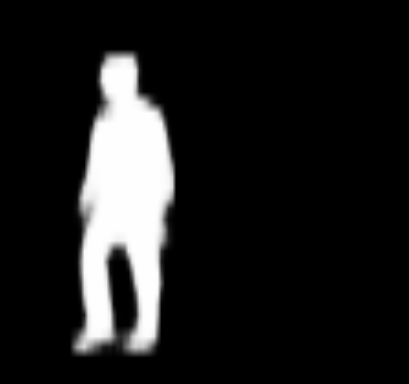

In [22]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
 
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
